# Code for making predictions with and without news features

## Libraries/Data required

In [201]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [202]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

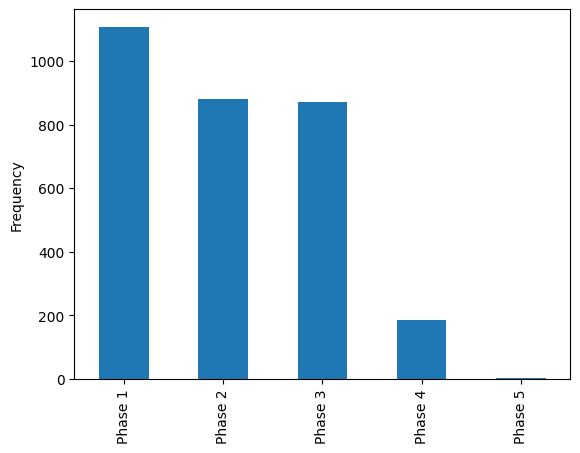

In [203]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

C:\Users\20203527\AppData\Local\Temp\ipykernel_12976\480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


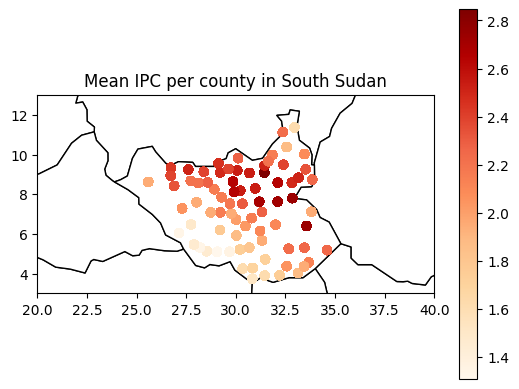

In [204]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [205]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [206]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [207]:
df

,,country,district_code,centx,centy,year_month,year,month,ipc,ha,ndvi_mean,...,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
date,district,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,South Sudan,74,32.00486,6.465644,2007_01,2007,1,NaN,NaN,0.345851,...,0.671249,0.048880,0,0,0.561363,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-02-01,Bor,South Sudan,74,32.00486,6.465644,2007_02,2007,2,NaN,NaN,0.307600,...,0.129184,-0.457928,0,0,0.565693,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-03-01,Bor,South Sudan,74,32.00486,6.465644,2007_03,2007,3,NaN,NaN,0.278344,...,1.025460,-0.590175,0,0,0.592437,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-04-01,Bor,South Sudan,74,32.00486,6.465644,2007_04,2007,4,NaN,NaN,0.303320,...,3.846809,-1.845536,0,0,0.605352,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-05-01,Bor,South Sudan,74,32.00486,6.465644,2007_05,2007,5,NaN,NaN,0.413716,...,8.316274,-2.972735,0,0,0.618699,14008.3300,7.961984,239344.0,11393.760,90.8503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,Malakal,South Sudan,151,31.64280,9.658457,2019_10,2019,10,3.0,0.0,0.681990,...,22.853360,6.053181,1,0,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000
2019-11-01,Malakal,South Sudan,151,31.64280,9.658457,2019_11,2019,11,NaN,NaN,0.556748,...,13.372410,8.745254,0,0,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000
2019-12-01,Malakal,South Sudan,151,31.64280,9.658457,2019_12,2019,12,NaN,NaN,0.400063,...,3.089540,1.698060,0,0,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000


In [208]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [209]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 17 Oct 2023   Prob (F-statistic):          4.40e-196
Time:                        09:42:04   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

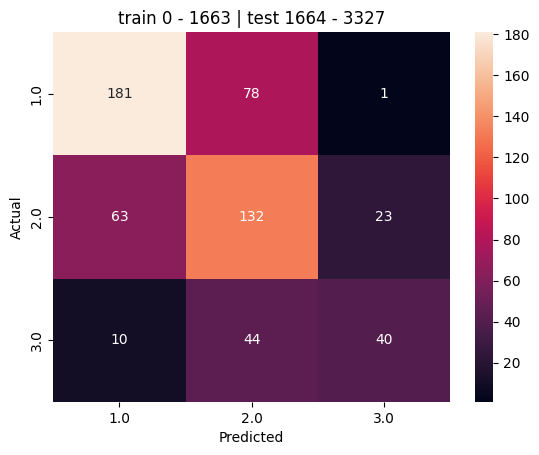

train accuraccy instant: 0.7713097713097713
test accuracy instant: 0.6171328671328671
                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     549.6
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:42:05   Log-Likelihood:                -1508.3
No. Observations:                2626   AIC:                             3031.
Df Residuals:                    2619   BIC:                             3072.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

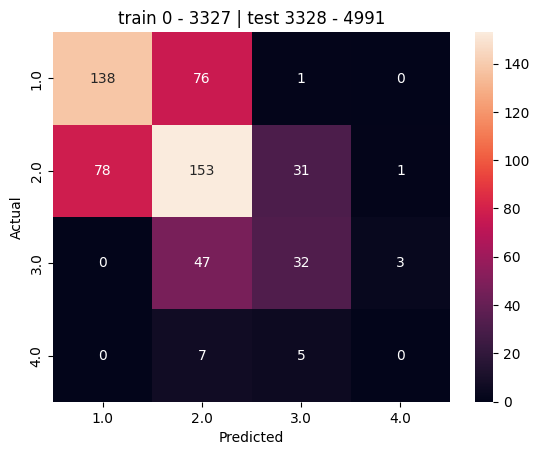

train accuraccy instant: 0.6287128712871287
test accuracy instant: 0.5646853146853147
                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     931.0
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:42:05   Log-Likelihood:                -2591.1
No. Observations:                4290   AIC:                             5196.
Df Residuals:                    4283   BIC:                             5241.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

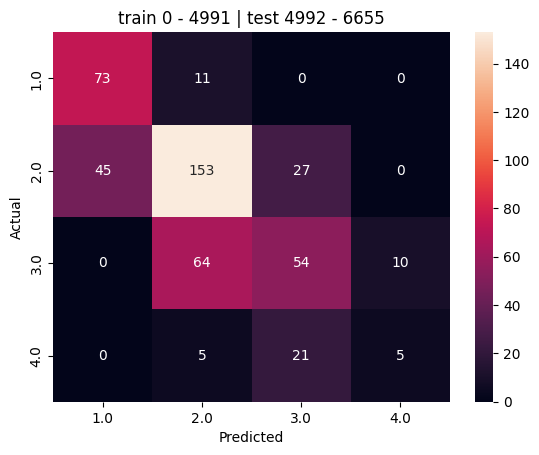

train accuraccy instant: 0.5874125874125874
test accuracy instant: 0.6089743589743589
                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1791.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:42:06   Log-Likelihood:                -3594.1
No. Observations:                5954   AIC:                             7202.
Df Residuals:                    5947   BIC:                             7249.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

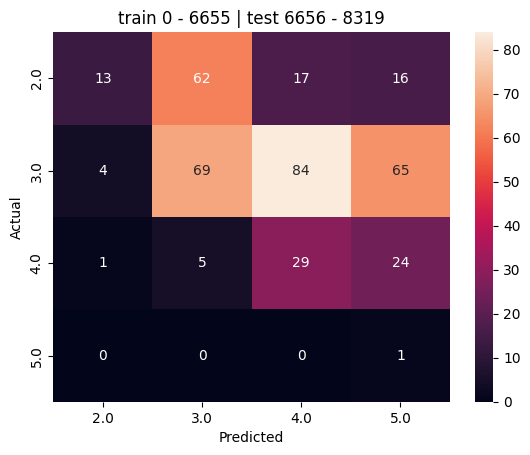

train accuraccy instant: 0.5856567013772254
test accuracy instant: 0.28717948717948716
                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2985.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:42:06   Log-Likelihood:                -4798.7
No. Observations:                7618   AIC:                             9611.
Df Residuals:                    7611   BIC:                             9660.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

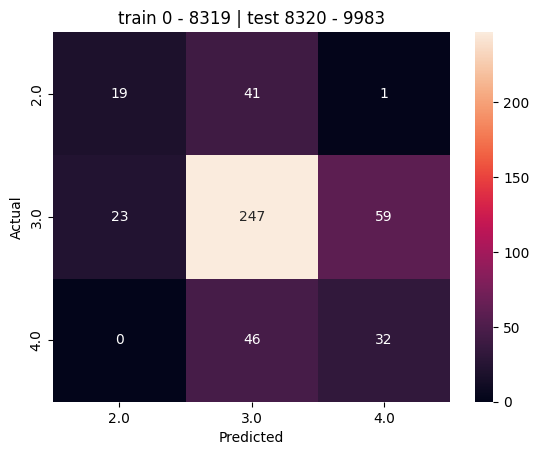

train accuraccy instant: 0.5622210553951168
test accuracy instant: 0.6367521367521367
Mean MAE: 0.59
Mean R2: 0.62
Mean train accuraccy: 0.63
Mean test accuraccy: 0.54


<Figure size 640x480 with 0 Axes>

In [210]:
X = df.iloc[:, -6:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
train_accuraccy = list()
test_accuraccy = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']); # Plot confusion matrix

    # Calculate accuraccy
    train_correct = ((results.predict(X_train).round()==y_train['ipc']).sum()) # ammount of correct train predictions
    test_correct = ((y_pred.round()==y_val['ipc']).sum()) # ammount of correct test predictions
    train_values_count = len(y_train['ipc'])-results.predict(X_train).round().isna().sum() # train values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
    test_values_count = len(y_val['ipc'])-y_val['ipc'].isna().sum() # test values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values

    # Append accuraccy to respective lists
    train_accuraccy.append(train_correct/train_values_count)
    test_accuraccy.append(test_correct/test_values_count)
    print(f"train accuraccy instant: {train_correct/train_values_count}")
    print(f"test accuracy instant: {test_correct/test_values_count}")
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [211]:
base_news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
base_news_df["date"] = pd.to_datetime(
    pd.to_datetime(base_news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
base_news_df.head()

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict
0,The article discusses the passing of the new C...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
1,The article discusses the military actions tak...,2011-07-01,Abyei,9.838551,28.486396,False,False,False,False
2,The article discusses the signing of a Framewo...,2011-06-01,Southern Kordofan,11.036544,30.895824,False,False,False,False
3,The article discusses the upcoming independenc...,2011-07-01,South Sudan,6.876992,31.306979,False,False,False,False
4,The article discusses the need for South Sudan...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False


In [212]:
# news_df = pd.read_csv("df_rake_paragraphs.csv") # Read news data into DataFrame

# # Create date column
# news_df["date"] = pd.to_datetime(
#     pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
#     format="%Y-%m",
# )
# news_df.columns

### New ones

In [217]:
pd.set_option('display.max_columns', None) # Display all columns in DataFrame

In [218]:
news_rp_df = pd.read_csv("df_rake_paragraphs.csv") # Read news data into DataFrame

# Create date column
news_rp_df["date"] = pd.to_datetime(
    pd.to_datetime(news_rp_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_rp_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['government'],['people'],['juba'],['president'],['state'],['peace'],['security'],['international'],['conflict'],['year'],['national'],['united'],['war'],['political']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",True,False,False,False,False,False,False,False,False,False,True,False,False,False
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [219]:
news_rs_df = pd.read_csv("df_rake_summary.csv") # Read news data into DataFrame

# Create date column
news_rs_df["date"] = pd.to_datetime(
    pd.to_datetime(news_rs_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_rs_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['government'],['president'],['peace'],['juba'],['conflict'],['security'],['violence'],['international'],['un'],['support'],['humanitarian'],['oil'],['war'],['machar']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [220]:
news_yp_df = pd.read_csv("df_yake_paragraphs.csv") # Read news data into DataFrame

# Create date column
news_yp_df["date"] = pd.to_datetime(
    pd.to_datetime(news_yp_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_yp_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['juba'],['abyei'],['president'],['machar'],['Uganda'],['jonglei'],['darfur'],['nile'],['minister'],['nuer'],['khartoum'],['government'],['police'],['ethiopia']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,True,False,False,False,True,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,True,False,False,False,True,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [221]:
news_ys_df = pd.read_csv("df_yake_summary.csv") # Read news data into DataFrame

# Create date column
news_ys_df["date"] = pd.to_datetime(
    pd.to_datetime(news_ys_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_ys_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['president'],['jonglei'],['uganda'],['abyei'],['machar'],['united'],['bor'],['ethiopia'],['republic'],['ababa'],['bentiu'],['malakal'],['kenya'],['unity']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",False,False,False,False,False,False,False,False,True,False,False,False,False,True
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,True,False,False,False,False,True
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [222]:
news_gpt_df = pd.read_csv("df_gpt.csv") # Read news data into DataFrame

# Create date column
news_gpt_df["date"] = pd.to_datetime(
    pd.to_datetime(news_gpt_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_gpt_df.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,['Independence'],['Secession'],['Conflict'],['Famine'],['Peace'],['Refugees'],['Ethnicity'],['UNMISS'],['SPLA'],['Oil'],['Displacement'],['Children'],['Referendum'],['Instability'],['Clashes'],['Drought'],['Corruption'],['Mediation'],['Crisis'],['Rebel']
0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...",False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...",True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [223]:
def create_news_features(input_news_df, columns):
    cols = []
    for column in columns:
        col = input_news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [230]:
# # country wide news features
news_features_base = create_news_features(base_news_df, [base_news_df.columns[-4:]])
news_features_rp = create_news_features(news_rp_df, [news_rp_df.columns[-14:]])
news_features_rs = create_news_features(news_rs_df, [news_rs_df.columns[-14:]])
news_features_yp = create_news_features(news_yp_df, [news_yp_df.columns[-14:]])
news_features_ys = create_news_features(news_ys_df, [news_ys_df.columns[-14:]])
news_features_gpt = create_news_features(news_gpt_df, [news_gpt_df.columns[-20:]])
print(len(news_features_base.columns))
news_features_base

4


,hunger,refugees,humanitarian,conflict
date,,,,
2011-06-01,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-12-01,0.022222,0.027778,0.044444,4.625929e-18
2023-01-01,0.022222,0.027778,0.044444,4.625929e-18
2023-02-01,0.083333,0.027778,0.041667,4.625929e-18


In [266]:
ndf = df.copy()
ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
ndf = ndf.join(news_features_base, how="left") # Join df with created news features
test = ndf.iloc[:,-10:-4]
test = sm.add_constant(test) # Add constant column of 1s for intercept
test

const  count_violence_lag_3  ndvi_anom_lag_3  \
date       district                                                     
2009-07-01 Abiemnhom       1.0              0.000000        95.891380   
           Akobo           1.0              0.333333       111.870073   
           Anzara          1.0              0.000000       103.035443   
           Aweil Center    1.0              0.000000       106.495113   
           Aweil East      1.0              0.000000       102.086478   
...                        ...                   ...              ...   
2020-02-01 Wulu            1.0              0.000000       103.909292   
           Yambio          1.0              0.500000       101.517510   
           Yei             1.0              2.333333       102.151617   
           Yirol East      1.0              0.166667       103.811285   
           Yirol West      1.0              0.833333       102.977952   

                         food_price_idx_lag_3  ipc_lag_1  ipc_lag_2  ipc_lag_3  
date       district                                                             
2009-07-01 Abiemnhom                 0.007091        NaN        NaN        NaN  
           Akobo                     0.005769        NaN        NaN        NaN  
           Anzara                    0.005331        NaN        NaN        NaN  
           Aweil Center              0.023279        NaN        NaN        NaN  
           Aweil East                0.013091        NaN        NaN        NaN  
...                                       ...        ...        ...        ...  
2020-02-01 Wulu                      2.463037        2.0        3.0        3.0  
           Yambio                    2.371327        2.0        3.0        3.0  
           Yei                       3.138777        3.0        3.0        3.0  
           Yirol East                3.468092        3.0        4.0        4.0  
           Yirol West                3.407927        3.0        4.0        4.0  

[9984 rows x 7 columns]

## Creating the prediction model

In [346]:
def train_model(features_df):

    ndf = df.copy()
    ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
    ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf = ndf.join(features_df, how="left") # Join df with created news features

    all_mae_values = list()
    all_r2_values = list()
    all_train_accuraccy = list()
    all_test_accuraccy = list()

    for i in range(len(features_df.columns)+1):
        start = -len(features_df.columns)-6
        end = -len(features_df.columns) + i
        print(f"Start: {start}, End: {end}")
        if end == 0:
            X = ndf.iloc[:, start:] # Define explanatory variables
            X = sm.add_constant(X) # Add constant column of 1s for intercept
        else:
            X = ndf.iloc[:, start:(end)] # Define explanatory variables
            X = sm.add_constant(X) # Add constant column of 1s for intercept
        y = ndf[["ipc"]] # Define target data

        cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

        # Initinalize empty lists to score scores
        mae_values = list()
        r2_values = list()
        train_accuraccy = list()
        test_accuraccy = list()

        for train_index, val_index in cv.split(X): # Loop over the different training-test splits

            # Define X and y data
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
            X_train = X_train.dropna(axis=1, how='all').copy()
            X_test = X_test[X_train.columns]
            
            #Interpolate training data to generate more training points
            X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
            X_train.reset_index(level=0, drop=True, inplace=True)
            y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
            y_train.reset_index(level=0, drop=True, inplace=True)

            model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
            results = model.fit() # Get model results on training data
            #print(results.summary()) # Print model summary

            y_pred = results.predict(X_test) # Run model on test data
            
            # Append results to respective lists
            mae_values.append((y_pred - y_val['ipc']).abs().mean())
            r2_values.append(results.rsquared)

            # plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
            # plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

            # Calculate accuraccy
            train_correct = ((results.predict(X_train).round()==y_train['ipc']).sum()) # ammount of correct train predictions
            test_correct = ((y_pred.round()==y_val['ipc']).sum()) # ammount of correct test predictions
            train_values_count = len(y_train['ipc'])-results.predict(X_train).round().isna().sum() # train values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
            test_values_count = len(y_val['ipc'])-y_val['ipc'].isna().sum() # test values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
        
            # Append accuraccy to respective lists
            train_accuraccy.append(train_correct/train_values_count)
            test_accuraccy.append(test_correct/test_values_count)
        
        # print(f"Number of features: {len(X.columns)-1}")
        # print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
        # print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
        # print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
        # print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy
        # print('-------------------------')

        all_mae_values.append(np.mean(mae_values))
        all_r2_values.append(np.mean(r2_values))
        all_train_accuraccy.append(np.mean(train_accuraccy))
        all_test_accuraccy.append(np.mean(test_accuraccy))
    # print("")
    # print(f"All MAE values: {all_mae_values}")
    # print(f"All R2 values: {all_r2_values}")
    # print(f"All train accuracy values: {all_train_accuraccy}")
    # print(f"All test accuracy values: {all_test_accuraccy}")
    return all_mae_values, all_r2_values, all_train_accuraccy, all_test_accuraccy

## Predicting using news features

### Base model

In [347]:
base_mae_values, base_r2_values, base_train_accuracy, base_test_accuracy = train_model(news_features_base)

Start: -10, End: -4
Start: -10, End: -3
Start: -10, End: -2
Start: -10, End: -1
Start: -10, End: 0


### Plotting the results

In [349]:
# #plot MAE, accuraccy and R2 for different number of features
# figure, axis = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)
# axis[0].plot(base_mae_values, label='MAE')
# axis[2].plot(base_r2_values, label='R2')
# axis[1].plot(base_train_accuracy, label='Train accuraccy')
# axis[1].plot(base_test_accuracy, label='Test accuraccy')
# axis[0].legend()
# axis[1].legend()
# axis[2].legend()
# axis[0].set_title('MAE')
# axis[1].set_title('Accuraccy')
# axis[2].set_title('R2')
# axis[0].set_xlabel('Number of features')
# axis[1].set_xlabel('Number of features')
# axis[2].set_xlabel('Number of features')
# axis[0].set_ylim(0, 1)
# axis[1].set_ylim(0, 1)
# axis[2].set_ylim(0, 1)
# figure.suptitle('Base: MAE, Accuraccy and R2 for different number of features', fontsize=16);

### rake paragraphs

In [350]:
rp_mae_values, rp_r2_values, rp_train_accuracy, rp_test_accuracy = train_model(news_features_rp)

Start: -20, End: -14
Start: -20, End: -13
Start: -20, End: -12
Start: -20, End: -11
Start: -20, End: -10
Start: -20, End: -9
Start: -20, End: -8
Start: -20, End: -7
Start: -20, End: -6
Start: -20, End: -5
Start: -20, End: -4
Start: -20, End: -3
Start: -20, End: -2
Start: -20, End: -1
Start: -20, End: 0


### Plotting the results

In [351]:
# #plot MAE, accuraccy and R2 for different number of features
# figure, axis = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)
# axis[0].plot(rp_mae_values, label='MAE')
# axis[2].plot(rp_r2_values, label='R2')
# axis[1].plot(rp_train_accuracy, label='Train accuraccy')
# axis[1].plot(rp_test_accuracy, label='Test accuraccy')
# axis[0].legend()
# axis[1].legend()
# axis[2].legend()
# axis[0].set_title('MAE')
# axis[1].set_title('Accuraccy')
# axis[2].set_title('R2')
# axis[0].set_xlabel('Number of features')
# axis[1].set_xlabel('Number of features')
# axis[2].set_xlabel('Number of features')
# axis[0].set_ylim(0, 1)
# axis[1].set_ylim(0, 1)
# axis[2].set_ylim(0, 1)
# figure.suptitle('Rake on Paragraphs: MAE, Accuraccy and R2 for different number of features', fontsize=16);

### rake summaries

In [352]:
rs_mae_values, rs_r2_values, rs_train_accuracy, rs_test_accuracy = train_model(news_features_rs)

Start: -20, End: -14


Start: -20, End: -13
Start: -20, End: -12
Start: -20, End: -11
Start: -20, End: -10
Start: -20, End: -9
Start: -20, End: -8
Start: -20, End: -7
Start: -20, End: -6
Start: -20, End: -5
Start: -20, End: -4
Start: -20, End: -3
Start: -20, End: -2
Start: -20, End: -1
Start: -20, End: 0


### Plotting the results

In [353]:
# #plot MAE, accuraccy and R2 for different number of features
# figure, axis = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)
# axis[0].plot(rs_mae_values, label='MAE')
# axis[2].plot(rs_r2_values, label='R2')
# axis[1].plot(rs_train_accuracy, label='Train accuraccy')
# axis[1].plot(rs_test_accuracy, label='Test accuraccy')
# axis[0].legend()
# axis[1].legend()
# axis[2].legend()
# axis[0].set_title('MAE')
# axis[1].set_title('Accuraccy')
# axis[2].set_title('R2')
# axis[0].set_xlabel('Number of article features')
# axis[1].set_xlabel('Number of article features')
# axis[2].set_xlabel('Number of article features')
# axis[0].set_ylim(0, 1)
# axis[1].set_ylim(0, 1)
# axis[2].set_ylim(0, 1)
# figure.suptitle('Rake on Summaries: MAE, Accuraccy and R2 for different number of features', fontsize=16);

### yake paragraphs

In [354]:
yp_mae_values, yp_r2_values, yp_train_accuracy, yp_test_accuracy = train_model(news_features_yp)

Start: -20, End: -14
Start: -20, End: -13
Start: -20, End: -12
Start: -20, End: -11
Start: -20, End: -10
Start: -20, End: -9
Start: -20, End: -8
Start: -20, End: -7
Start: -20, End: -6
Start: -20, End: -5
Start: -20, End: -4
Start: -20, End: -3
Start: -20, End: -2
Start: -20, End: -1
Start: -20, End: 0


### Plotting the results

In [355]:
# #plot MAE, accuraccy and R2 for different number of features
# figure, axis = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)
# axis[0].plot(yp_mae_values, label='MAE')
# axis[2].plot(yp_r2_values, label='R2')
# axis[1].plot(yp_train_accuracy, label='Train accuraccy')
# axis[1].plot(yp_test_accuracy, label='Test accuraccy')
# axis[0].legend()
# axis[1].legend()
# axis[2].legend()
# axis[0].set_title('MAE')
# axis[1].set_title('Accuraccy')
# axis[2].set_title('R2')
# axis[0].set_xlabel('Number of features')
# axis[1].set_xlabel('Number of features')
# axis[2].set_xlabel('Number of features')
# axis[0].set_ylim(0, 1)
# axis[1].set_ylim(0, 1)
# axis[2].set_ylim(0, 1)
# figure.suptitle('Yake on Paragraphs: MAE, Accuraccy and R2 for different number of features', fontsize=16);

### yake summaries

In [356]:
ys_mae_values, ys_r2_values, ys_train_accuracy, ys_test_accuracy = train_model(news_features_ys)

Start: -20, End: -14
Start: -20, End: -13
Start: -20, End: -12
Start: -20, End: -11
Start: -20, End: -10
Start: -20, End: -9
Start: -20, End: -8
Start: -20, End: -7
Start: -20, End: -6
Start: -20, End: -5
Start: -20, End: -4
Start: -20, End: -3
Start: -20, End: -2
Start: -20, End: -1
Start: -20, End: 0


### Plotting the results

In [357]:
# #plot MAE, accuraccy and R2 for different number of features
# figure, axis = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)
# axis[0].plot(ys_mae_values, label='MAE')
# axis[2].plot(ys_r2_values, label='R2')
# axis[1].plot(ys_train_accuracy, label='Train accuraccy')
# axis[1].plot(ys_test_accuracy, label='Test accuraccy')
# axis[0].legend()
# axis[1].legend()
# axis[2].legend()
# axis[0].set_title('MAE')
# axis[1].set_title('Accuraccy')
# axis[2].set_title('R2')
# axis[0].set_xlabel('Number of features')
# axis[1].set_xlabel('Number of features')
# axis[2].set_xlabel('Number of features')
# axis[0].set_ylim(0, 1)
# axis[1].set_ylim(0, 1)
# axis[2].set_ylim(0, 1)
# figure.suptitle('Yake on Summaries: MAE, Accuraccy and R2 for different number of features', fontsize=16);

### GPT keywords

In [358]:
gpt_mae_values, gpt_r2_values, gpt_train_accuracy, gpt_test_accuracy = train_model(news_features_gpt)

Start: -26, End: -20
Start: -26, End: -19
Start: -26, End: -18
Start: -26, End: -17
Start: -26, End: -16
Start: -26, End: -15
Start: -26, End: -14
Start: -26, End: -13
Start: -26, End: -12
Start: -26, End: -11
Start: -26, End: -10
Start: -26, End: -9
Start: -26, End: -8
Start: -26, End: -7
Start: -26, End: -6
Start: -26, End: -5
Start: -26, End: -4
Start: -26, End: -3
Start: -26, End: -2
Start: -26, End: -1
Start: -26, End: 0


### Plotting the results

In [359]:
# #plot MAE, accuraccy and R2 for different number of features
# figure, axis = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)
# axis[0].plot(gpt_mae_values, label='MAE')
# axis[2].plot(gpt_r2_values, label='R2')
# axis[1].plot(gpt_train_accuracy, label='Train accuraccy')
# axis[1].plot(gpt_test_accuracy, label='Test accuraccy')
# axis[0].legend()
# axis[1].legend()
# axis[2].legend()
# axis[0].set_title('MAE')
# axis[1].set_title('Accuraccy')
# axis[2].set_title('R2')
# axis[0].set_xlabel('Number of features')
# axis[1].set_xlabel('Number of features')
# axis[2].set_xlabel('Number of features')
# axis[0].set_ylim(0, 1)
# axis[1].set_ylim(0, 1)
# axis[2].set_ylim(0, 1)
# figure.suptitle('GPT keywords: MAE, Accuraccy and R2 for different number of features', fontsize=16);

### combined general plot

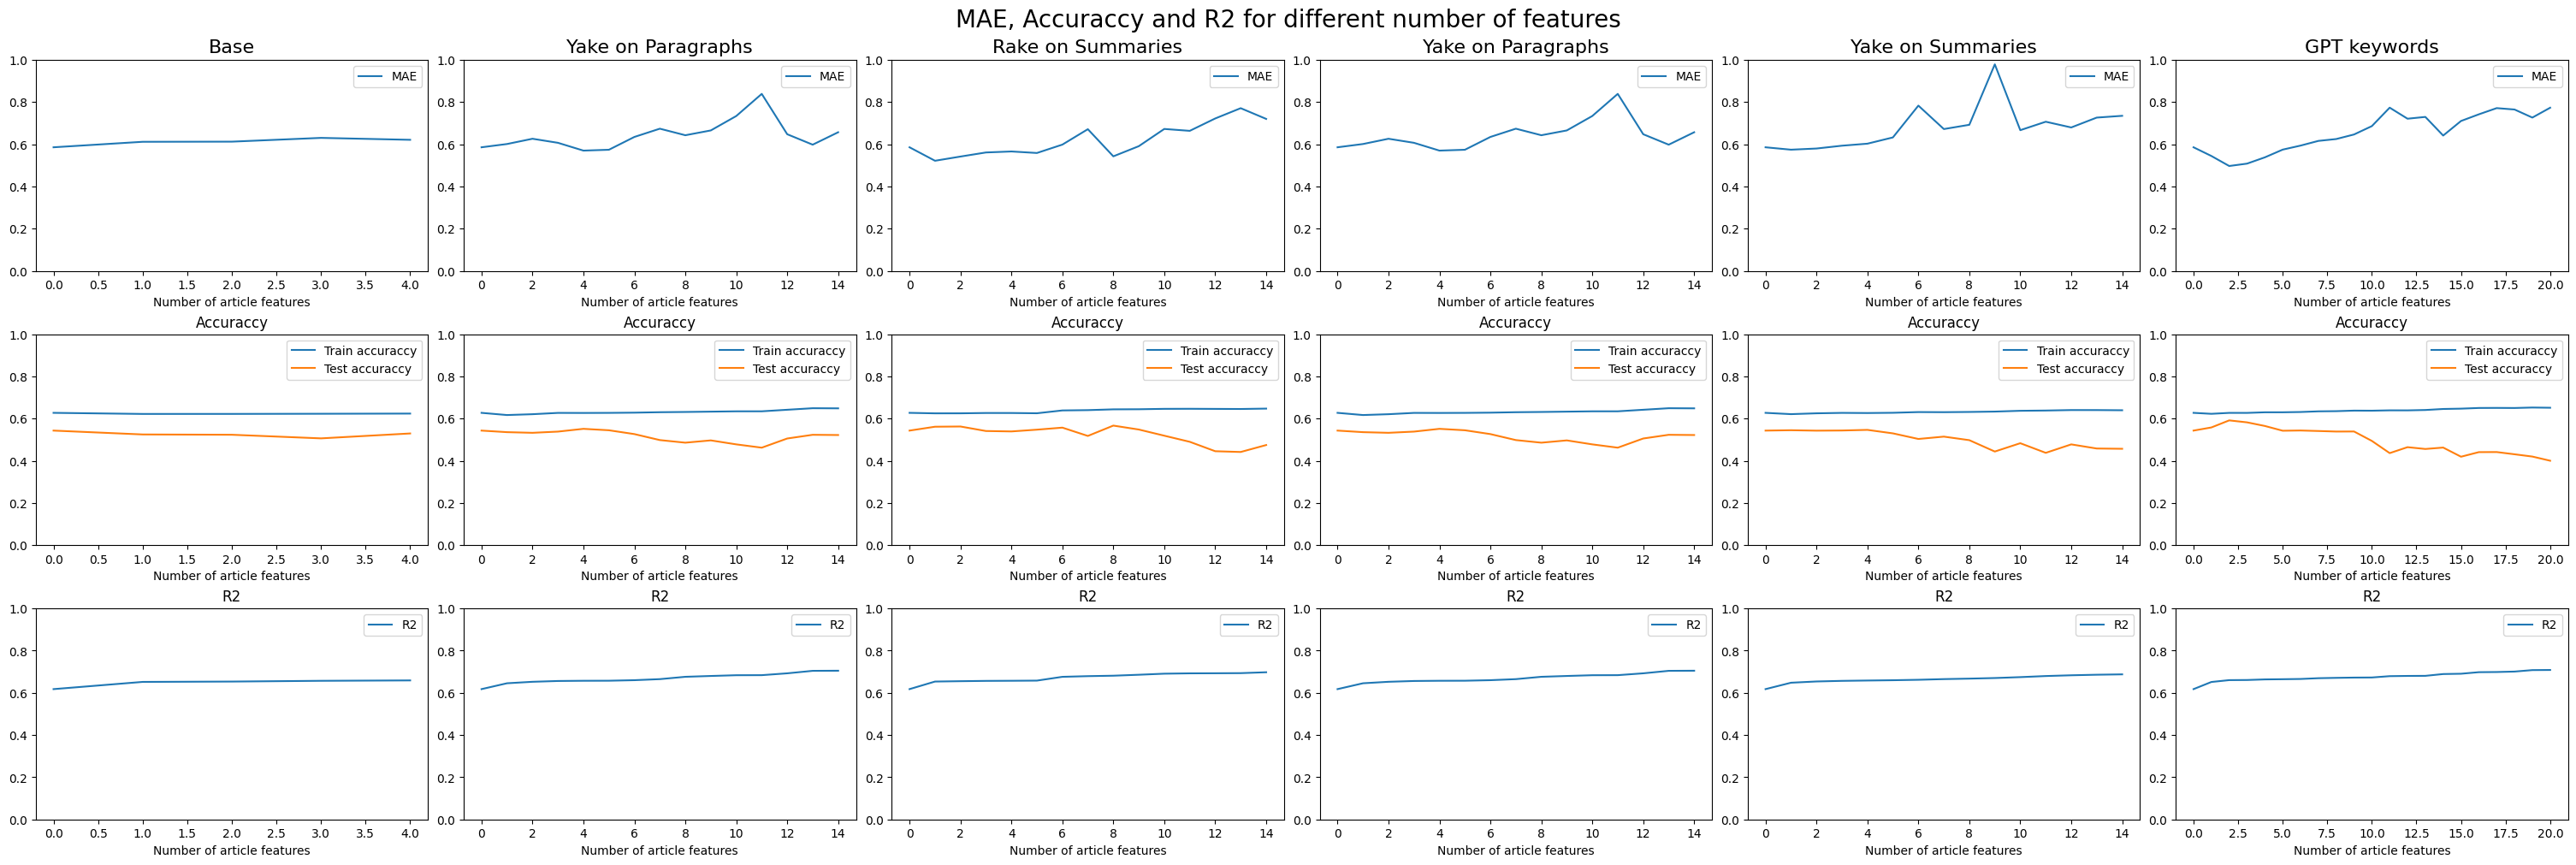

In [360]:
#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 6, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='MAE')
axis[2,0].plot(base_r2_values, label='R2')
axis[1,0].plot(base_train_accuracy, label='Train accuraccy')
axis[1,0].plot(base_test_accuracy, label='Test accuraccy')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of article features')
axis[1,0].set_xlabel('Number of article features')
axis[2,0].set_xlabel('Number of article features')
axis[0,0].set_ylim(0, 1)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(yp_mae_values, label='MAE')
axis[2,1].plot(yp_r2_values, label='R2')
axis[1,1].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,1].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of article features')
axis[1,1].set_xlabel('Number of article features')
axis[2,1].set_xlabel('Number of article features')
axis[0,1].set_ylim(0, 1)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='MAE')
axis[2,2].plot(rs_r2_values, label='R2')
axis[1,2].plot(rs_train_accuracy, label='Train accuraccy')
axis[1,2].plot(rs_test_accuracy, label='Test accuraccy')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of article features')
axis[1,2].set_xlabel('Number of article features')
axis[2,2].set_xlabel('Number of article features')
axis[0,2].set_ylim(0, 1)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='MAE')
axis[2,3].plot(yp_r2_values, label='R2')
axis[1,3].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,3].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of article features')
axis[1,3].set_xlabel('Number of article features')
axis[2,3].set_xlabel('Number of article features')
axis[0,3].set_ylim(0, 1)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='MAE')
axis[2,4].plot(ys_r2_values, label='R2')
axis[1,4].plot(ys_train_accuracy, label='Train accuraccy')
axis[1,4].plot(ys_test_accuracy, label='Test accuraccy')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of article features')
axis[1,4].set_xlabel('Number of article features')
axis[2,4].set_xlabel('Number of article features')
axis[0,4].set_ylim(0, 1)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='MAE')
axis[2,5].plot(gpt_r2_values, label='R2')
axis[1,5].plot(gpt_train_accuracy, label='Train accuraccy')
axis[1,5].plot(gpt_test_accuracy, label='Test accuraccy')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of article features')
axis[1,5].set_xlabel('Number of article features')
axis[2,5].set_xlabel('Number of article features')
axis[0,5].set_ylim(0, 1)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

## Only articles

In [361]:
def train_model_only_articles(features_df):

    ndf = df.copy()
    ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
    ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf = ndf.join(features_df, how="left") # Join df with created news features

    all_mae_values = list()
    all_r2_values = list()
    all_train_accuraccy = list()
    all_test_accuraccy = list()

    for i in range(len(features_df.columns)):
        start = -len(features_df.columns)
        end = -len(features_df.columns) + i + 1
        print(f"Start: {start}, End: {end}")
        if end == 0:
            X = ndf.iloc[:, start:] # Define explanatory variables
            X = sm.add_constant(X) # Add constant column of 1s for intercept
        else:
            X = ndf.iloc[:, start:(end)] # Define explanatory variables
            X = sm.add_constant(X) # Add constant column of 1s for intercept
        y = ndf[["ipc"]] # Define target data

        cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

        # Initinalize empty lists to score scores
        mae_values = list()
        r2_values = list()
        train_accuraccy = list()
        test_accuraccy = list()

        for train_index, val_index in cv.split(X): # Loop over the different training-test splits

            # Define X and y data
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
            X_train = X_train.dropna(axis=1, how='all').copy()
            X_test = X_test[X_train.columns]
            
            #Interpolate training data to generate more training points
            X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
            X_train.reset_index(level=0, drop=True, inplace=True)
            y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
            y_train.reset_index(level=0, drop=True, inplace=True)

            model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
            results = model.fit() # Get model results on training data
            #print(results.summary()) # Print model summary

            y_pred = results.predict(X_test) # Run model on test data
            
            # Append results to respective lists
            mae_values.append((y_pred - y_val['ipc']).abs().mean())
            r2_values.append(results.rsquared)

            # plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
            # plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

            # Calculate accuraccy
            train_correct = ((results.predict(X_train).round()==y_train['ipc']).sum()) # ammount of correct train predictions
            test_correct = ((y_pred.round()==y_val['ipc']).sum()) # ammount of correct test predictions
            train_values_count = len(y_train['ipc'])-results.predict(X_train).round().isna().sum() # train values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
            test_values_count = len(y_val['ipc'])-y_val['ipc'].isna().sum() # test values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
        
            # Append accuraccy to respective lists
            train_accuraccy.append(train_correct/train_values_count)
            test_accuraccy.append(test_correct/test_values_count)
        
        # print(f"Number of features: {len(X.columns)-1}")
        # print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
        # print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
        # print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
        # print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy
        # print('-------------------------')

        all_mae_values.append(np.mean(mae_values))
        all_r2_values.append(np.mean(r2_values))
        all_train_accuraccy.append(np.mean(train_accuraccy))
        all_test_accuraccy.append(np.mean(test_accuraccy))
    # print("")
    # print(f"All MAE values: {all_mae_values}")
    # print(f"All R2 values: {all_r2_values}")
    # print(f"All train accuracy values: {all_train_accuraccy}")
    # print(f"All test accuracy values: {all_test_accuraccy}")
    return all_mae_values, all_r2_values, all_train_accuraccy, all_test_accuraccy

### running the model on the data

In [362]:
base_mae_values_articles, base_r2_values_articles, base_train_accuracy_articles, base_test_accuracy_articles = train_model_only_articles(news_features_base)
rp_mae_values_articles, rp_r2_values_articles, rp_train_accuracy_articles, rp_test_accuracy_articles = train_model_only_articles(news_features_rp)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles(news_features_rs)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles(news_features_rs)
yp_mae_values_articles, yp_r2_values_articles, yp_train_accuracy_articles, yp_test_accuracy_articles = train_model_only_articles(news_features_yp)
ys_mae_values_articles, ys_r2_values_articles, ys_train_accuracy_articles, ys_test_accuracy_articles = train_model_only_articles(news_features_ys)
gpt_mae_values_articles, gpt_r2_values_articles, gpt_train_accuracy_articles, gpt_test_accuracy_articles = train_model_only_articles(news_features_gpt)

Start: -4, End: -3
Start: -4, End: -2
Start: -4, End: -1
Start: -4, End: 0
Start: -14, End: -13
Start: -14, End: -12
Start: -14, End: -11
Start: -14, End: -10
Start: -14, End: -9
Start: -14, End: -8
Start: -14, End: -7
Start: -14, End: -6
Start: -14, End: -5
Start: -14, End: -4
Start: -14, End: -3
Start: -14, End: -2
Start: -14, End: -1
Start: -14, End: 0
Start: -14, End: -13
Start: -14, End: -12
Start: -14, End: -11
Start: -14, End: -10
Start: -14, End: -9
Start: -14, End: -8
Start: -14, End: -7
Start: -14, End: -6
Start: -14, End: -5
Start: -14, End: -4
Start: -14, End: -3
Start: -14, End: -2
Start: -14, End: -1
Start: -14, End: 0
Start: -14, End: -13
Start: -14, End: -12
Start: -14, End: -11
Start: -14, End: -10
Start: -14, End: -9
Start: -14, End: -8
Start: -14, End: -7
Start: -14, End: -6
Start: -14, End: -5
Start: -14, End: -4
Start: -14, End: -3
Start: -14, End: -2
Start: -14, End: -1
Start: -14, End: 0
Start: -14, End: -13
Start: -14, End: -12
Start: -14, End: -11
Start: -14, E

In [326]:
base_mae_values_articles, base_r2_values_articles, base_train_accuracy_articles, base_test_accuracy_articles = train_model_only_articles(news_features_base)

Number of features: 1
Mean MAE: 0.78
Mean R2: 0.03
Mean train accuraccy: 0.32
Mean test accuraccy: 0.35
-------------------------
Number of features: 2
Mean MAE: 0.78
Mean R2: 0.05
Mean train accuraccy: 0.32
Mean test accuraccy: 0.36
-------------------------
Number of features: 3
Mean MAE: 0.79
Mean R2: 0.07
Mean train accuraccy: 0.32
Mean test accuraccy: 0.35
-------------------------
Number of features: 4
Mean MAE: 0.78
Mean R2: 0.07
Mean train accuraccy: 0.32
Mean test accuraccy: 0.35
-------------------------

All MAE values: [0.7811483109489152, 0.7795704011846943, 0.7863754537538096, 0.78265959059998]
All R2 values: [0.02840250376652278, 0.05330777212814837, 0.06733342985270188, 0.0734501773719198]
All train accuracy values: [0.3186622076089212, 0.3224431724068352, 0.317619045016685, 0.3204809978786378]
All test accuracy values: [0.35380730380730385, 0.35723387723387723, 0.34578865578865575, 0.3531313131313131]


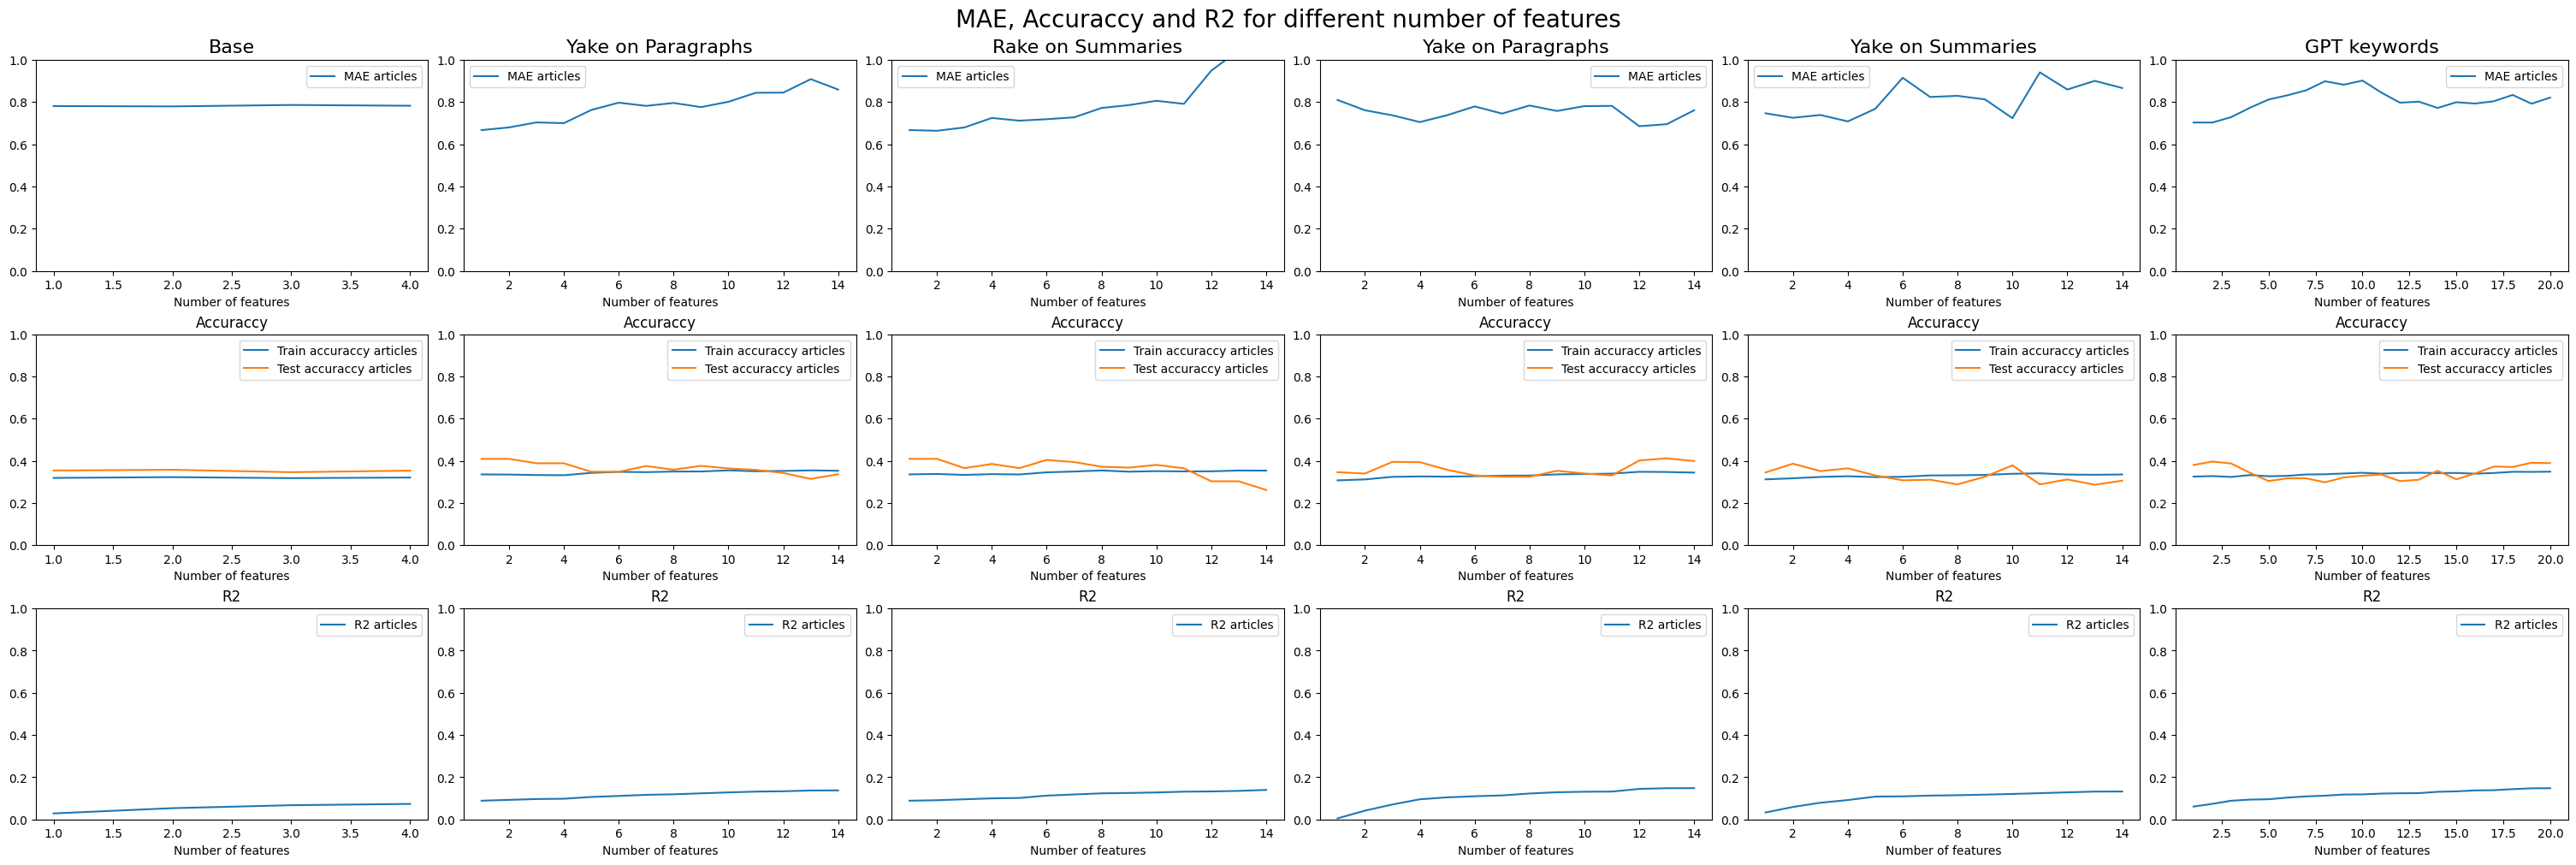

In [368]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 15)]
gpt_article_xvals = [i for i in range(1, 21)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 6, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='MAE articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='R2 articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='Train accuraccy articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='Test accuraccy articles')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylim(0, 1)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(article_xvals, rp_mae_values_articles, label='MAE articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='R2 articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 1)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(article_xvals, rs_mae_values_articles, label='MAE articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='R2 articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='Train accuraccy articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='Test accuraccy articles')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 1)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(article_xvals, yp_mae_values_articles, label='MAE articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='R2 articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 1)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(article_xvals, ys_mae_values_articles, label='MAE articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='R2 articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='Train accuraccy articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='Test accuraccy articles')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 1)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='MAE articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='R2 articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='Train accuraccy articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='Test accuraccy articles')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 1)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

In [323]:
len(yp_mae_values_articles)

14

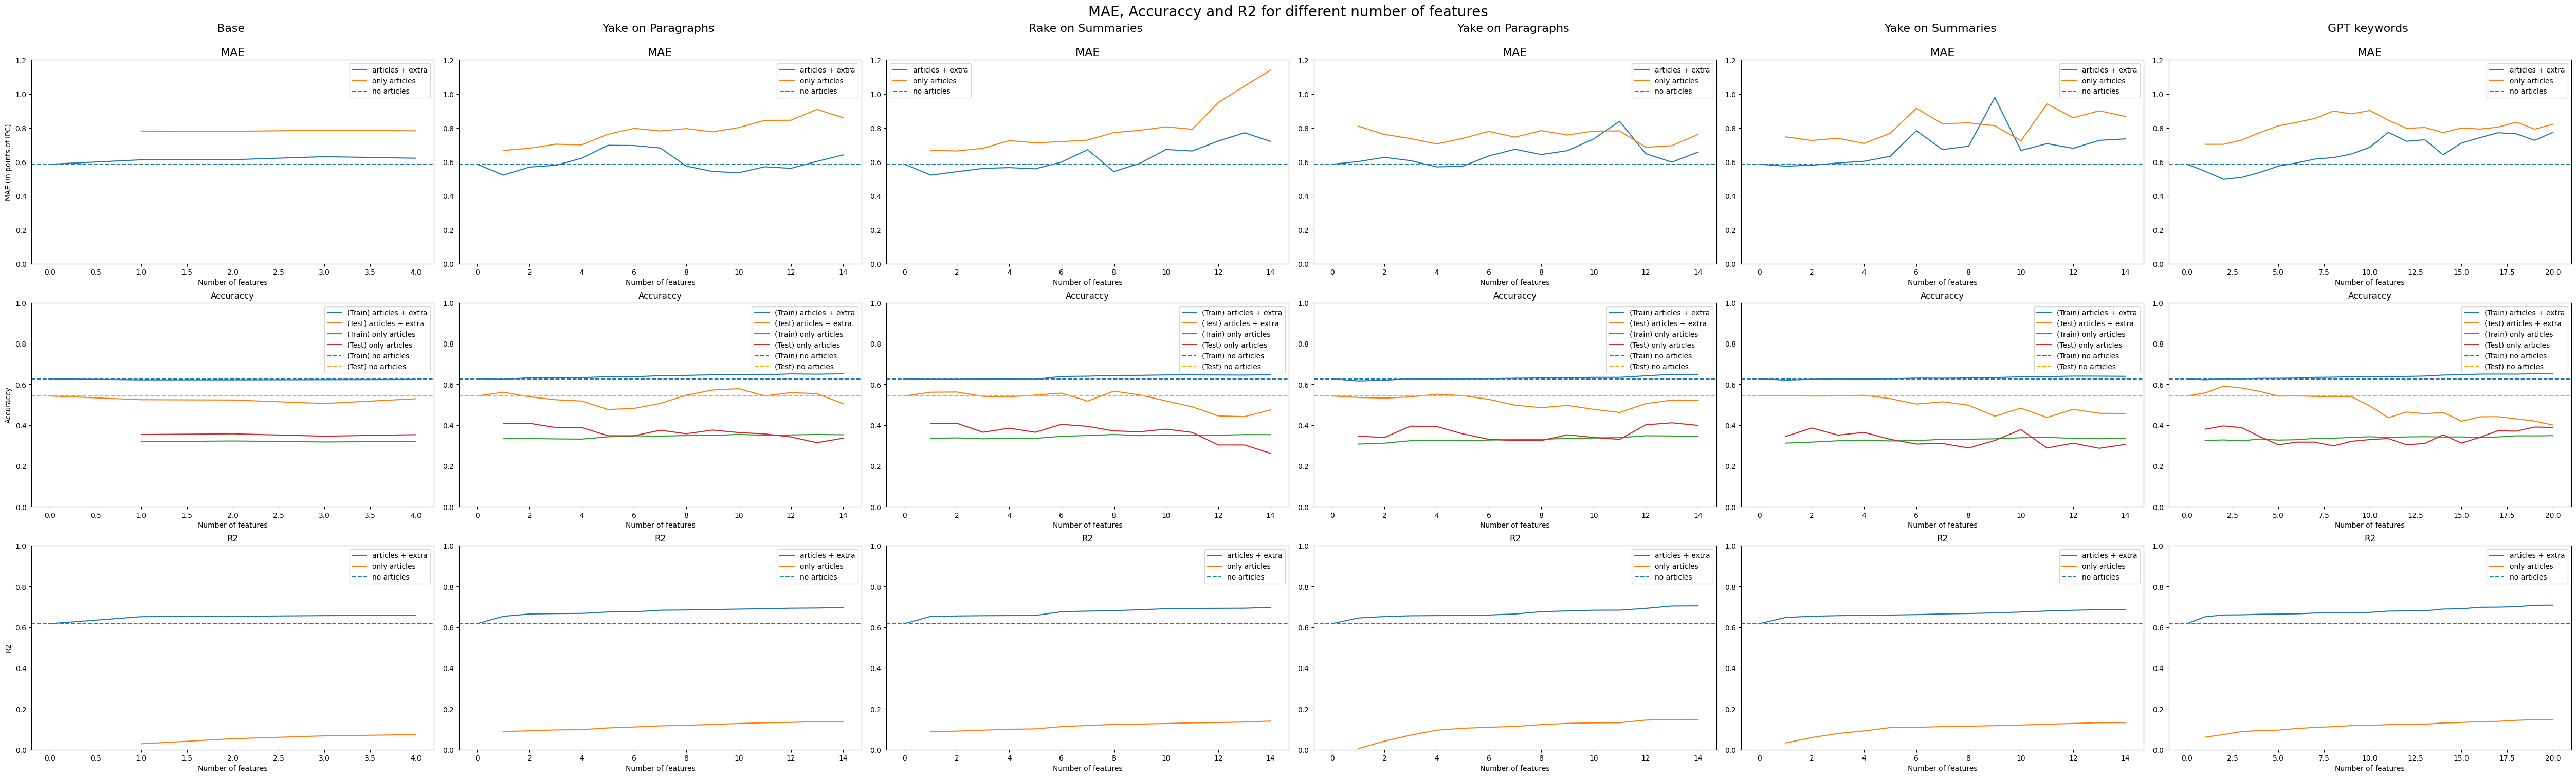

In [389]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 15)]
gpt_article_xvals = [i for i in range(1, 21)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 6, figsize=(50, 15), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='articles + extra')
axis[2,0].plot(base_r2_values, label='articles + extra')
axis[1,0].plot(base_train_accuracy, label='(Train) articles + extra')
axis[1,0].plot(base_test_accuracy, label='(Test) articles + extra')

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='only articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='only articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='(Train) only articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='(Test) only articles')

axis[0,0].axhline(base_mae_values[0], linestyle='--', label='no articles')
axis[2,0].axhline(base_r2_values[0], linestyle='--', label='no articles')
axis[1,0].axhline(base_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,0].axhline(base_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylabel('MAE (in points of IPC)')
axis[1,0].set_ylabel('Accuraccy')
axis[2,0].set_ylabel('R2')
axis[0,0].set_ylim(0, 1.2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(rp_mae_values, label='articles + extra')
axis[2,1].plot(rp_r2_values, label='articles + extra')
axis[1,1].plot(rp_train_accuracy, label='(Train) articles + extra')
axis[1,1].plot(rp_test_accuracy, label='(Test) articles + extra')

axis[0,1].plot(article_xvals, rp_mae_values_articles, label='only articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='only articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='(Train) only articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='(Test) only articles')

axis[0,1].axhline(rp_mae_values[0], linestyle='--', label='no articles')
axis[2,1].axhline(rp_r2_values[0], linestyle='--', label='no articles')
axis[1,1].axhline(rp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,1].axhline(rp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 1.2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='articles + extra')
axis[2,2].plot(rs_r2_values, label='articles + extra')
axis[1,2].plot(rs_train_accuracy, label='(Train) articles + extra')
axis[1,2].plot(rs_test_accuracy, label='(Test) articles + extra')

axis[0,2].plot(article_xvals, rs_mae_values_articles, label='only articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='only articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='(Train) only articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='(Test) only articles')

axis[0,2].axhline(rs_mae_values[0], linestyle='--', label='no articles')
axis[2,2].axhline(rs_r2_values[0], linestyle='--', label='no articles')
axis[1,2].axhline(rs_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,2].axhline(rs_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 1.2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='articles + extra')
axis[2,3].plot(yp_r2_values, label='articles + extra')
axis[1,3].plot(yp_train_accuracy, label='(Train) articles + extra')
axis[1,3].plot(yp_test_accuracy, label='(Test) articles + extra')

axis[0,3].plot(article_xvals, yp_mae_values_articles, label='only articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='only articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='(Train) only articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='(Test) only articles')

axis[0,3].axhline(yp_mae_values[0], linestyle='--', label='no articles')
axis[2,3].axhline(yp_r2_values[0], linestyle='--', label='no articles')
axis[1,3].axhline(yp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,3].axhline(yp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 1.2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='articles + extra')
axis[2,4].plot(ys_r2_values, label='articles + extra')
axis[1,4].plot(ys_train_accuracy, label='(Train) articles + extra')
axis[1,4].plot(ys_test_accuracy, label='(Test) articles + extra')

axis[0,4].plot(article_xvals, ys_mae_values_articles, label='only articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='only articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='(Train) only articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='(Test) only articles')

axis[0,4].axhline(ys_mae_values[0], linestyle='--', label='no articles')
axis[2,4].axhline(ys_r2_values[0], linestyle='--', label='no articles')
axis[1,4].axhline(ys_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,4].axhline(ys_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 1.2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='articles + extra')
axis[2,5].plot(gpt_r2_values, label='articles + extra')
axis[1,5].plot(gpt_train_accuracy, label='(Train) articles + extra')
axis[1,5].plot(gpt_test_accuracy, label='(Test) articles + extra')

axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='only articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='only articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='(Train) only articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,5].axhline(gpt_mae_values[0], linestyle='--', label='no articles')
axis[2,5].axhline(gpt_r2_values[0], linestyle='--', label='no articles')
axis[1,5].axhline(gpt_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,5].axhline(gpt_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 1.2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords \n\nMAE', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [30]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

Optimization terminated successfully.
         Current function value: 0.023951
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                  962
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 Oct 2023   Pseudo R-squ.:                  0.7213
Time:                        14:36:26   Log-Likelihood:                -23.041
converged:                       True   LL-Null:                       -82.676
Covariance Type:            nonrobust   LLR p-value:                 1.108e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.9214      2.560     -6.610      0.000     -21.939     -11.904
ipc_lag_1      7.5452      1

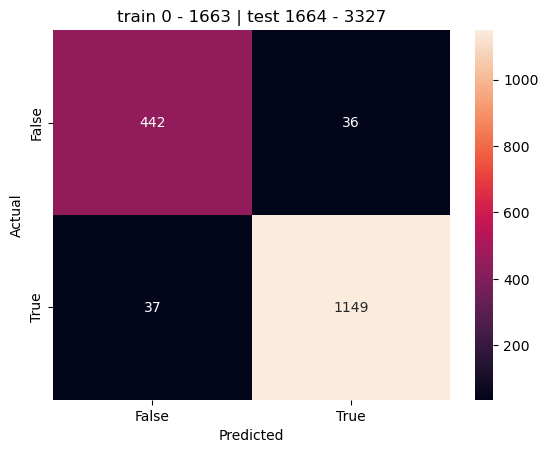

Optimization terminated successfully.
         Current function value: 0.196510
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 2626
Model:                          Logit   Df Residuals:                     2622
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 Oct 2023   Pseudo R-squ.:                  0.4129
Time:                        14:36:26   Log-Likelihood:                -516.04
converged:                       True   LL-Null:                       -878.95
Covariance Type:            nonrobust   LLR p-value:                5.241e-157
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0771      0.344    -23.471      0.000      -8.752      -7.403
ipc_lag_1      3.0044      0.

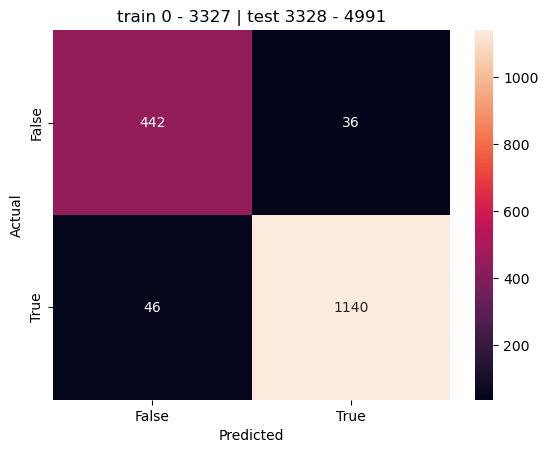

Optimization terminated successfully.
         Current function value: 0.220939
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 4290
Model:                          Logit   Df Residuals:                     4286
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 Oct 2023   Pseudo R-squ.:                  0.3941
Time:                        14:36:26   Log-Likelihood:                -947.83
converged:                       True   LL-Null:                       -1564.4
Covariance Type:            nonrobust   LLR p-value:                4.853e-267
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8526      0.262    -29.949      0.000      -8.367      -7.339
ipc_lag_1      2.9520      0.

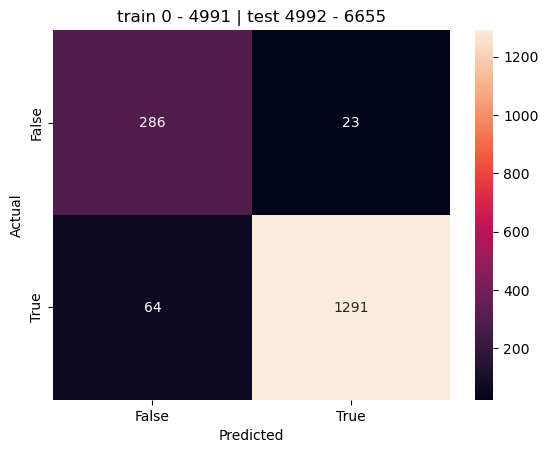

Optimization terminated successfully.
         Current function value: 0.263542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 5954
Model:                          Logit   Df Residuals:                     5950
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 Oct 2023   Pseudo R-squ.:                  0.4349
Time:                        14:36:27   Log-Likelihood:                -1569.1
converged:                       True   LL-Null:                       -2776.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8860      0.209    -37.780      0.000      -8.295      -7.477
ipc_lag_1      2.8618      0.

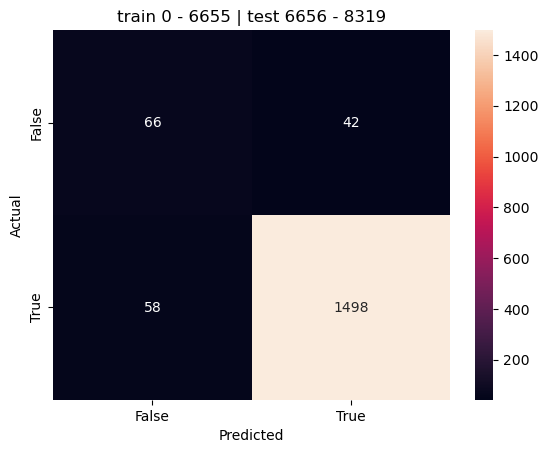

Optimization terminated successfully.
         Current function value: 0.297659
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 7618
Model:                          Logit   Df Residuals:                     7614
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 Oct 2023   Pseudo R-squ.:                  0.5120
Time:                        14:36:27   Log-Likelihood:                -2267.6
converged:                       True   LL-Null:                       -4646.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2706      0.182    -45.491      0.000      -8.627      -7.914
ipc_lag_1      2.6647      0.

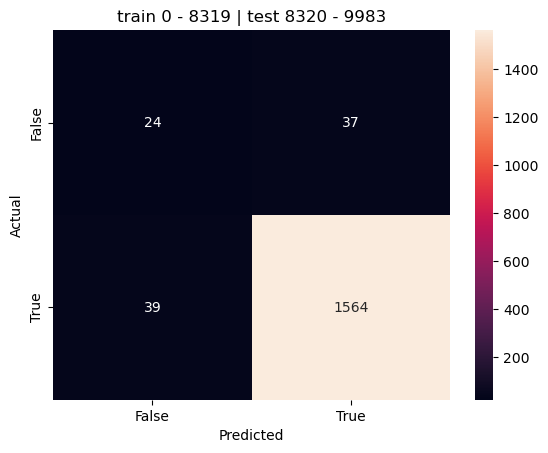

Mean Acc: 0.95


<Figure size 640x480 with 0 Axes>

In [31]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc